In [61]:
import pandas as pd
import streamlit
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from rich.console import Console
import json
import geopandas as gpd
from rich.table import Table

In [2]:
data_path = "dataset/input/world-university-rankings/"
cwur_data = data_path + "cwur_data.csv"
education_expenditure_supplementary_data = data_path + "education_expenditure_supplementary_data.csv"
educational_attainment_supplementary_data = data_path + "educational_attainment_supplementary_data.csv"
school_and_country_table = data_path + "school_and_country_table.csv"
shanghaiData = data_path + "shanghai_data.csv"
times_data = data_path + "times_data.csv"

geo_api_endpoint = "http://api.positionstack.com/v1/forward"

console = Console()

In [3]:
def uni_serialize():
    df = pd.read_csv(cwur_data)
    return df

def get_geolocation(uni_name):
    GEO_API_KEY = "7e5af99fd356a3a854e866c2f16064eb"
    try:
        target = list(json.loads(requests.get(url=geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name}").text)["data"])[0]
        return {"latitude": target["latitude"], "longitude": target["longitude"]}
    except: 
        return {"latitude" : None, "longitude" : None} # проверяем есть ли в принципе данные о геолокации
    

def add_geo(df):
    geo_lat = []
    geo_lon =[]
    if ("latitude" in df.columns.values or "longitude" in df.columns.values) : return # проверяем есть ли уже данные о геолокации, чтобы не считать их дважды
    for _ in df["institution"]:
        searched = get_geolocation(_)
        geo_lat.append(searched["latitude"])
        geo_lon.append(searched["longitude"])
    df.insert(3, "Latitude", geo_lat, True)
    df.insert(4, "Longitude", geo_lon, True)
    return df

In [4]:
uni_data = uni_serialize()

получили базовую информацию об университетах из датасета. Добавим к этим данным их географическое положение через api [api.positionstack.com/v1](https://positionstack.com). Построим карту Америки и отметим на ней университеты, используя библиотеку geopandas. Я нашел в открытом доступе файлы с необходимыми для отображения карты Америки формами. [Источник](https://github.com/joncutrer/geopandas-tutorial/tree/master/data)

In [11]:
# segment = uni_data.head()
# segment = add_geo(segment)
uni_data = add_geo(uni_data)

In [173]:
geo_Latitude_NaN_count = uni_data.Latitude.isnull().sum()
geo_Longitude_NaN_count = uni_data.Longitude.isnull().sum()

table = Table()
table.add_column(header="latitude is Nan longitude is not NaN", style=" bold italic cyan")
table.add_column(header="longitude is NaN", style=" bold italic cyan")
table.add_row(str(geo_Latitude_NaN_count), str(geo_Longitude_NaN_count))
console.print(table)
console.print(f"both latitude and longitude is NaN\n{is_geo_both_NaN}")
console.print(f"[bold]No geolocation count:[/] {uni_data.Longitude.isnull().sum()}")

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ latitude is Nan longitude is not NaN ┃ longitude is NaN ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ 82                                   │ 82               │
└──────────────────────────────────────┴──────────────────┘

both latitude and longitude is NaN
0       True
1       True
2       True
3       True
4       True
        ... 
2195    True
2196    True
2197    True
2198    True
2199    True
Name: Longitude, Length: 2200, dtype: bool

No geolocation count: 82

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


Говорят, что вузы западного побережья круче Восточных. Проверим гиппотезу

In [78]:
# штаты западного и восточного побережья
west = [states["STUSPS"][i] for i in range(len(states)) if 'est' in states["region"][i]] 
east = [states["STUSPS"][i] for i in range(len(states)) if 'ast' in states["region"][i]] 

тут я вспомнил, что нужно много строчек..

In [172]:
usa_uni = uni_data.loc[uni_data['country'] == 'USA', ["institution","Longitude", "Latitude", 'national_rank']]


west_uni_avg = usa_uni.loc[usa_uni['Longitude'] < -95]

east_uni_avg = usa_uni.loc[usa_uni['Longitude'] >= -95]
console.print(f"East coast average national rating: {east_uni_avg.national_rank.mean()}\nWest coast average national rating: {west_uni_avg.national_rank.mean()}\n")

East coast average national rating: 98.4175
West coast average national rating: 93.85798816568047

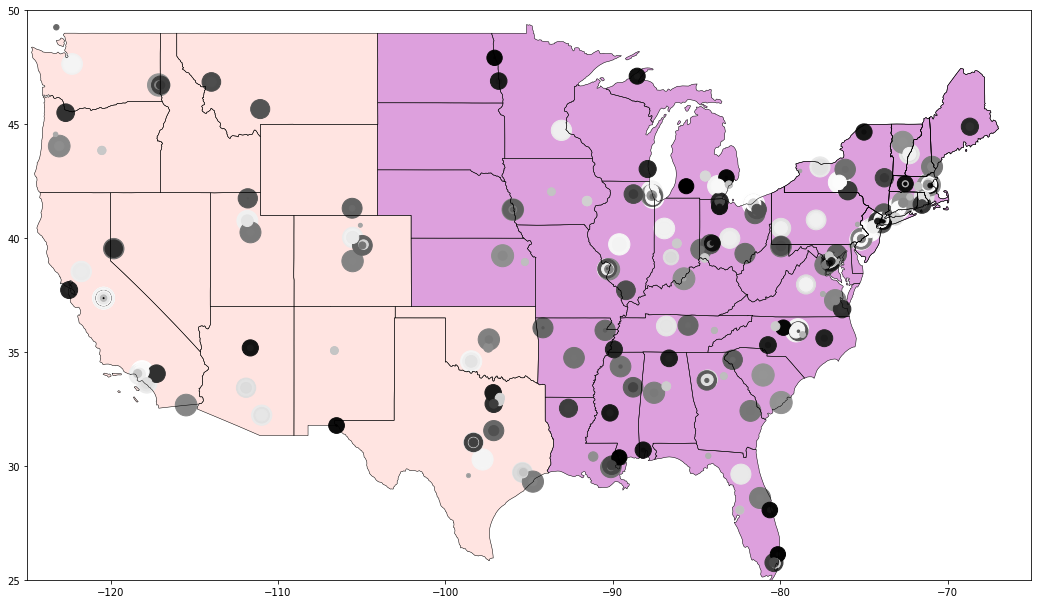

In [171]:
west = states[states['region'] == 'West']
southwest = states[states['region'] == 'Southwest']
southeast = states[states['region'] == 'Southeast']
midwest = states[states['region'] == 'Midwest']
northeast = states[states['region'] == 'Northeast']
us_boundary_map = states.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
west.plot(ax=us_boundary_map,  color="MistyRose")
southwest.plot(ax=us_boundary_map, color="MistyRose")
southeast.plot(ax=us_boundary_map, color="Plum")
midwest.plot(ax=us_boundary_map, color="Plum")
final_map = northeast.plot(ax=us_boundary_map, color="Plum")
plt.xlim(-125, -65)
plt.ylim(25, 50)
us_boundary_map.scatter(x=usa_uni["Longitude"], y=usa_uni["Latitude"],s=usa_uni["national_rank"][::-1]**(16/14),c=usa_uni["national_rank"], cmap="Greys"),



plt.show()